# üß™ √âtapes d'EDA recommand√©es

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Chargement des donn√©es
df = pd.read_csv("../data/raw/fraudTest.csv")

# Conversion types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Optionnel : Supprimer la colonne Unnamed
df.drop(columns=['Unnamed: 0'], inplace=True)

## üìä 1. Statistiques g√©n√©rales

- V√©rifie la distribution des montants (amt)
- Nombre de fraudes vs non fraudes

Fraud rate: 0.0038598644278853163


<Axes: title={'center': 'Fraud vs Non-Fraud'}, xlabel='is_fraud'>

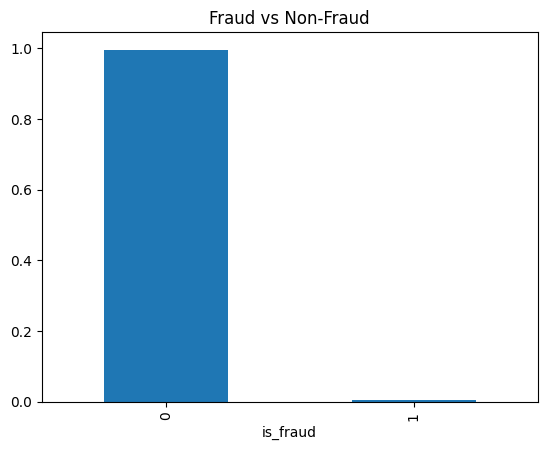

In [10]:
print("Fraud rate:", df["is_fraud"].mean())
df["is_fraud"].value_counts(normalize=True).plot(kind="bar", title="Fraud vs Non-Fraud")


## üïí 2. Transactions dans le temps

<Axes: title={'center': 'Daily Fraud Counts'}, xlabel='trans_date_trans_time'>

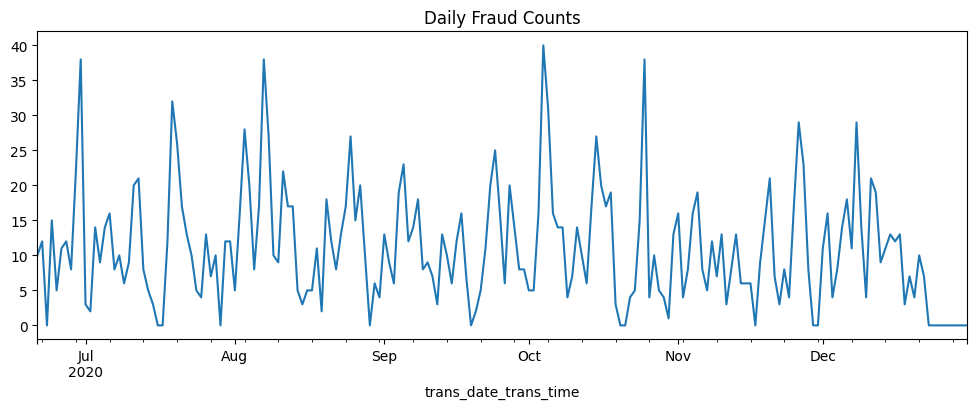

In [11]:
df.set_index("trans_date_trans_time").resample("D")["is_fraud"].sum().plot(title="Daily Fraud Counts", figsize=(12, 4))


## üó∫Ô∏è 3. Localisation : Merchants vs Clients

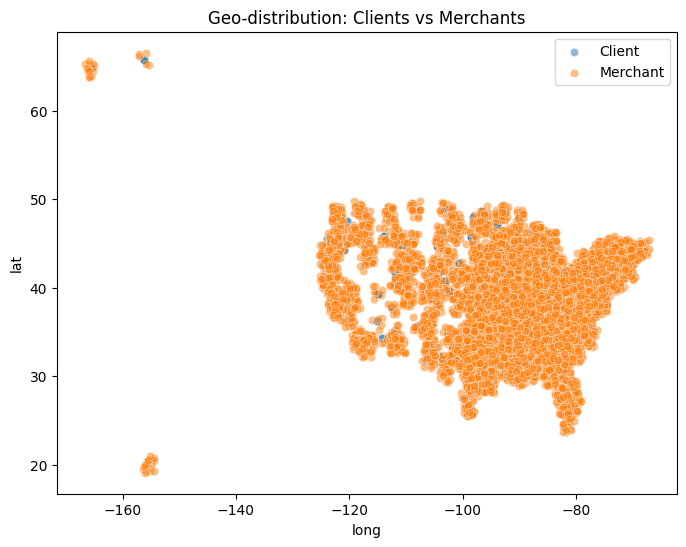

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='long', y='lat', data=df.sample(10000), alpha=0.5, label='Client')
sns.scatterplot(x='merch_long', y='merch_lat', data=df.sample(10000), alpha=0.5, label='Merchant')
plt.title("Geo-distribution: Clients vs Merchants")
plt.legend()

## üí∞ 4. Montant par cat√©gorie

Text(0.5, 1.0, 'Montants des transactions par cat√©gorie (filtr√© < 1000)')

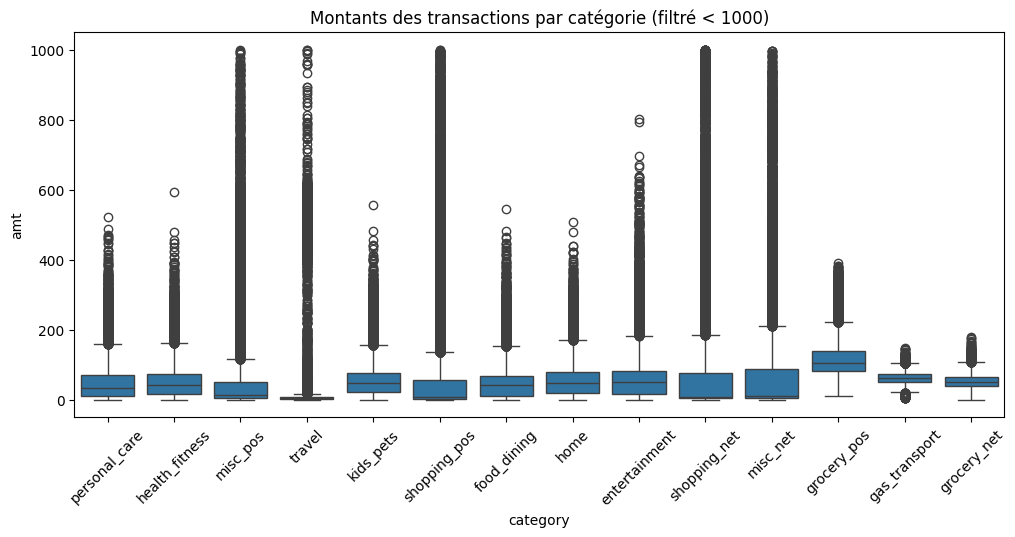

In [13]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="category", y="amt", data=df[df["amt"] < 1000])
plt.xticks(rotation=45)
plt.title("Montants des transactions par cat√©gorie (filtr√© < 1000)")


## üß™ 5. Fraude par cat√©gorie

<Axes: title={'center': 'Taux de fraude par cat√©gorie'}, xlabel='category'>

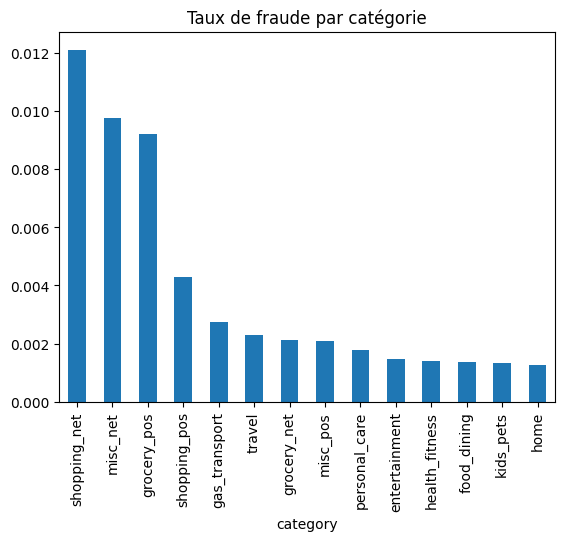

In [14]:
fraud_rate_by_cat = df.groupby("category")["is_fraud"].mean().sort_values(ascending=False)
fraud_rate_by_cat.plot(kind="bar", title="Taux de fraude par cat√©gorie")


## üß† 6. Age vs Fraude

Text(0.5, 1.0, "Distribution de l'√¢ge - fraud vs non-fraud")

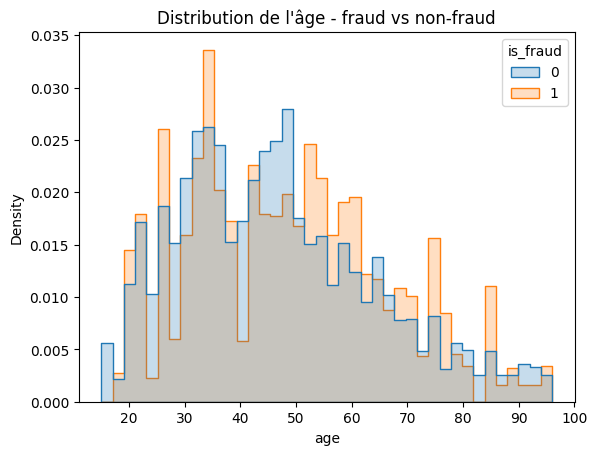

In [15]:
df["age"] = df["trans_date_trans_time"].dt.year - df["dob"].dt.year
sns.histplot(data=df, x="age", bins=40, hue="is_fraud", element="step", stat="density", common_norm=False)
plt.title("Distribution de l'√¢ge - fraud vs non-fraud")


## üöπ 7. Genre vs Fraude

Text(0.5, 1.0, 'Taux de fraude par genre')

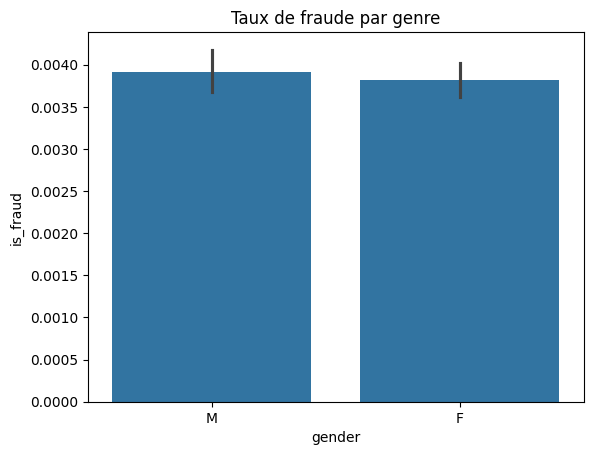

In [16]:
sns.barplot(x="gender", y="is_fraud", data=df)
plt.title("Taux de fraude par genre")


## üìä Rapport EDA ‚Äî Automatic Fraud Detection

### 1. **D√©s√©quilibre fort de classes**

![is\_fraud](sandbox:/mnt/data/isfraud.png)

* Seules **\~0.39%** des transactions sont frauduleuses.
* ‚û§ Cela confirme qu‚Äôil faudra :

  * g√©rer le d√©s√©quilibre avec `class_weights` ou `scale_pos_weight` (CatBoost),
  * suivre des m√©triques adapt√©es comme **F1 / AUC** (pas l‚Äôaccuracy !).

---

### 2. **Impact du type de d√©pense**

![fraud\_par\_cat](sandbox:/mnt/data/fraud_par_cat.png)

* Cat√©gories les plus √† risque :

  * `shopping_net`, `misc_net`, `grocery_pos`
* ‚û§ Feature tr√®s discriminante. √Ä encoder proprement.

---

### 3. **Montant par cat√©gorie**

![montant\_par\_cat](sandbox:/mnt/data/montant_par_cat.png)

* Beaucoup de cat√©gories ont une distribution biais√©e / skewed.
* ‚û§ Application possible d‚Äôun `log1p` sur le montant (`amt`) pour mod√©liser.

---

### 4. **√Çge et comportement frauduleux**

![fraud\_age](sandbox:/mnt/data/fraud_age.png)

* Les fraudes sont plus fr√©quentes entre **30-55 ans**.
* ‚û§ La feature `age` est informative, √† conserver !

---

### 5. **Genre et fraude**

![fraud\_genre](sandbox:/mnt/data/fraud_genre.png)

* Aucune diff√©rence significative entre `M` et `F`.
* ‚û§ √Ä inclure, mais avec faible importance probable.

---

### 6. **Saisonnalit√© temporelle**

![trans\_date](sandbox:/mnt/data/trans_date.png)

* Les fraudes fluctuent beaucoup, pas de tendance claire.
* ‚û§ Peut √™tre utile de cr√©er des features comme :

  * `dayofweek`, `hour`, `is_weekend`, etc.

---

### 7. **R√©partition g√©ographique**

![output](sandbox:/mnt/data/output.png)

* Distribution dense autour des grandes villes US.
* ‚û§ Un bon candidat pour cr√©er une **feature distance client-marchand**.

---

## üîß √âtape suivante : `02_preprocessing.py`

Voici un aper√ßu du **nettoyage / features √† pr√©parer** :

| Action                  | Variables concern√©es                             | D√©tail                                              |
| ----------------------- | ------------------------------------------------ | --------------------------------------------------- |
| üßπ Suppression colonnes | `first`, `last`, `street`, `trans_num`           | Pas utiles pour la pr√©diction                       |
| üìÖ Extraction date      | `trans_date_trans_time`, `dob`                   | Cr√©er `age`, `hour`, `dayofweek`, `month`           |
| üìè Distance             | `lat/long`, `merch_lat/merch_long`               | Haversine, ou eucl. distance                        |
| üî£ Encodage             | `gender`, `category`, `state`, `job`, `merchant` | Target encoding ou CatBoost natif                   |
| üí∞ Log-scale            | `amt`                                            | Transformation `np.log1p(amt)`                      |
| ‚öñÔ∏è Target imbalance     | `is_fraud`                                       | Pas d‚Äôundersampling ! G√©rer dans mod√®le directement |
